# Modelado de distribuciones por radio censal

Este notebook describe un caso de análisis de expansión urbana combinando recursos de los módulos `raster_data_analysis` y `spatial_distributions`. Con el primero, se genera el límite vectorial del extent de una mancha detectado para cada uno de los períodos censales considerados. Con el segundo, se estima el total de viviendas para un año proyectado y se las localiza en el territorio a partir de las distribuciones observadas en períodos censales previos y/o alguna relación espacial con otra variable relevante.     

El ejemplo que se describe a continuación se basa en la Ciudad de Corrientes y representa un caso de uso en el que, si bien el período proyectado cuenta con las geometrías de los radios censales, todavía se desconocen los resultados de la gran mayoría de las categorías de vivienda. La base de datos del precenso 2020 facilita el total de viviendas y de viviendas tipo casa/departamento. 
Asimismo, las categorías de la variable `tipo de vivienda` no son exactamente iguales a las formuladas en 2001 y 2020. El mejor dato al que se puede acceder sobre tipologías como `local no construído para habitación` es el porcentaje que esta categoría representa respecto del universo total de viviendas del departamento en el que se ubica la ciudad de análisis.


**A continuación se detalla:**

1. Una estrategia de distribución espacial de viviendas/hogares por radio censal, a partir de las distribuciones observadas en períodos previos y/o a la relación espacial con otros polígonos de interés.
2. Una estrategia de estimación de indicadores agregados a partir de las distintas categorías de hogares/viviendas disponibles en censos previos (2001 y 2010).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
from CENSAr.datasources import (
    tipoviv_radios_prov,
    radios_prov,
    radios_precenso_2020,
)

In [4]:
from CENSAr.plots import (
    compare_chropleths,
    )

In [5]:
from CENSAr.spatial_distributions.modeling_tools import (
    tracts_2020_to_2010,
    tracts_2010_to_2001,
    simulate_cat_var,
)

***Nota aclaratoria sobre el uso de las geometrías y las estrategias de estimación**

Los límites vectoriales que a continuación se cargan para cada uno de los tres períodos censales fueron construídos a partir del módulo `raster data analysis`.

Cada uno de ellos se utiliza como máscara de recorte para los polígonos de los radios censales disponibles en 2001, 2010 y 2020. 

In [6]:
# raster data analysis outputs
import geopandas as gpd
footpr_corrientes_00 = gpd.read_file('../../CENSAr/data/ManchaUrbana_Corrientes_1999.geojson')
footpr_corrientes_10 = gpd.read_file('../../CENSAr/data/ManchaUrbana_Corrientes_2010.geojson')
footpr_corrientes_20 = gpd.read_file('../../CENSAr/data/ManchaUrbana_Corrientes_2022.geojson')

In [7]:
# GEOMETRIAS
corrientes_2001 = radios_prov(year=2001, prov="corrientes", mask=footpr_corrientes_00)
corrientes_2010 = radios_prov(year=2010, prov="corrientes", mask=footpr_corrientes_10)
corrientes_2020 = radios_precenso_2020(geo_filter=None, mask=footpr_corrientes_20)

In [8]:
# TABLAS REDATAM - HOGARES/VIVIENDAS
#2001
tipo_vivienda_2001 = tipoviv_radios_prov(
    year=2001, prov="corrientes", var_types={"LINK": "object"}
)
tipo_vivienda_2001_geo = corrientes_2001.set_index("link").join(tipo_vivienda_2001.set_index("link"))

# 2010
tipo_vivienda_2010 = tipoviv_radios_prov(
    year=2010, prov="corrientes", var_types={"link": "object"}
)
tipo_vivienda_2010_geo = corrientes_2010.set_index("link").join(tipo_vivienda_2010.set_index("link"))

# 2020
corrientes_2020_ = tracts_2020_to_2010(
    tracts_2020_gdf=corrientes_2020, tracts_2010_gdf=corrientes_2010
)
# Verifico que todos los radios 2020 cuenten con referencia 2010
corrientes_2020_["link_2010"].isna().unique()

# Radios 2020 con referencias 2010 y 2001
tipo_vivienda_2020_geo = tracts_2010_to_2001(tracts_2020_gdf=corrientes_2020_, prov_name='corrientes')

[11:35:15] INFO     loading                                                                      ]8;id=281102;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=86379;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#111\111]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/tipo_vivienda_radios_                   
                    corrientes_2001.csv`                                                                           

           INFO     loading                                                                      ]8;id=380401;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=120621;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#111\111]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/tipo_vivienda_radios_                   
                    corrientes_2010.csv`                                                                           

[11:35:16] INFO     loadding                                                                     ]8;id=328406;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=611354;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#159\159]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/corrientes_tracts_pai                   
                    ring_0110.csv`                                                                                 

## 1. Total de viviendas por radio


<Axes: >

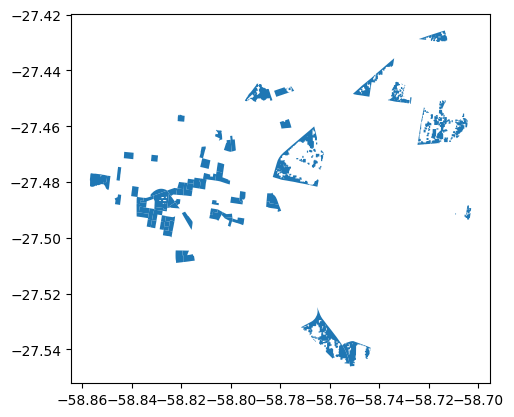

In [9]:
tipo_vivienda_2020_geo.loc[tipo_vivienda_2020_geo['total_viviendas']<300].plot()

{'scheme': 'NaturalBreaks', 'k': 4, 'colormap': 'Greys', 'legend': True, 'legend_kwds': {'fmt': '{:.0f}'}}


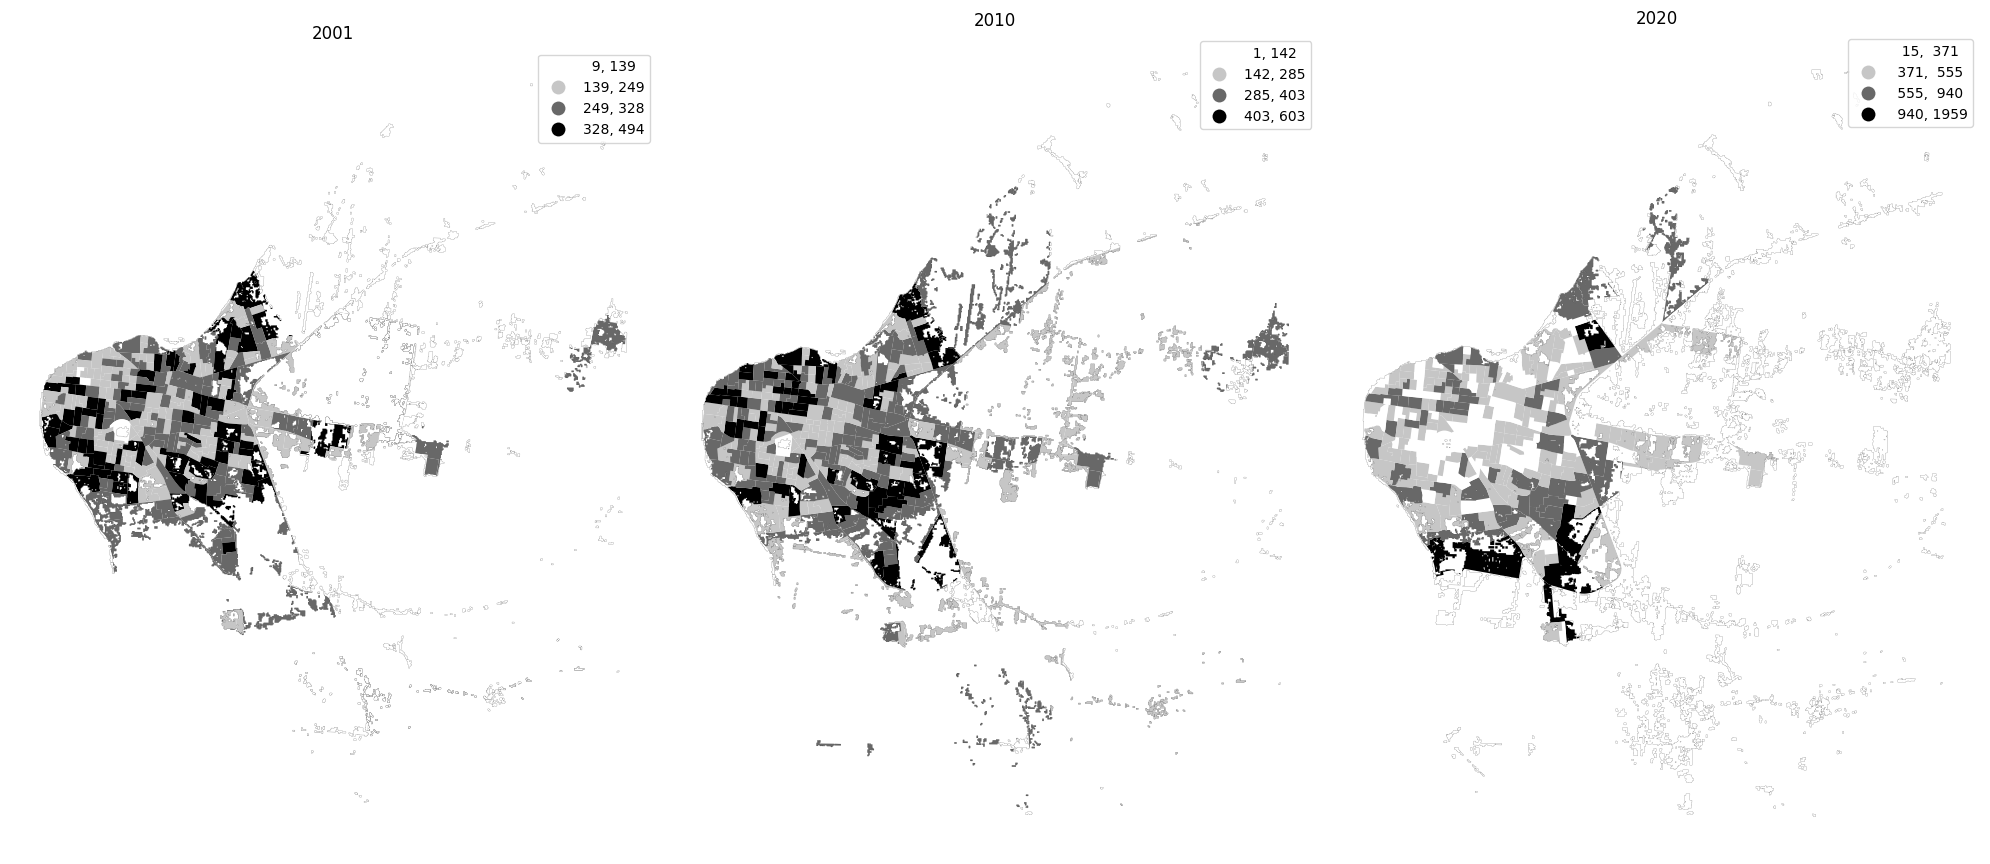

In [10]:
# Total de viviendas
compare_chropleths(
    tipo_vivienda_2001_geo,
    tipo_vivienda_2010_geo,
    tipo_vivienda_2020_geo,
    column=["total", "total", "total_viviendas"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [footpr_corrientes_00,footpr_corrientes_10,footpr_corrientes_20],
    figsize=(20,12),
    legend_kwds = {'fmt':'{:.0f}'},
    scheme = "NaturalBreaks",
    k = 4,
    colormap="Greys"
)

In [11]:
tipo_vivienda_2001_geo['total'].sum(), tipo_vivienda_2010_geo['total'].sum(), tipo_vivienda_2020_geo['total_viviendas'].sum()

(80922.0, 101885, 136509)

## 2. Total de viviendas por categoria simple

La función `simulate_cat_var` permite distribuir frecuencias de una variable a lo largo de un conjunto de radios censales siguiendo una serie de reglas. Entre ellas, es necesario definir a qué período censal corresponden las distribuciones observadas que se van a utilizar para realizar la asignación de frecuencias por radio en el año de proyección. Los parámetros `gdf_var_01` y `gdf_var_10` sirven para obtener esta información. Por su parte, `forecast_gdf` es donde se simulará la asignación de frecuencias por radio.  

Como se puede observar en la coropleta correspondiente a 2020, el extent parece ser más amplío. Esto es porque el mismo excede la información disponible por radio. 

Esta función recibe tres geodataframes. Dos para observar distribuciones por radio censal (`2001` y `2010`) y uno para modelar la distribución por radio en el año de proyección (`2020`).

La cantidad de viviendas de la categoría en cuestión se define a partir de un porcentaje teórico u observado. Este refleja el peso que tiene dicha categoría en el total de viviendas (e.g. `2.5%`). El parametro `pct_val` permite definir el total de frecuencias de una categoría específica a partir del total de frecuencias del universo en su conjunto. Esto permite analizar tanto escenarios de crecimiento como de decrecimiento (para esto último bastaría con definir un porcentaje inferior al observado en un período previo)

Además, la función `simulate_cat_var` cuenta con el parámetro `calibration_vector` que permite incorporar una nueva distribución observada por radio censal (utilizada para captar alguna relación espacial con otro polígono de interés). Más adelante, se ejemplifica su uso.

Con respecto al parámetro `catname`, vale aclarar que este se encuentra atado al `base_year`. Para reproducir una distribución observada en `2001`, el `catname` debe indicar el nombre de la columna de valores por radio en dicho dataset. En cambio, si se buscara reproducir una distribución intermedia entre lo observado en 2001 y 2010, `base_year` debería especificarse como `0110`. En esa situación, `catname` podría definirse bajo un mismo `str` para los dos años (2001 y 2010). Es decir, ese sería el nombre de la columna en los dos geodatasets utilizados para reprodución la distribución (e.g. 'casilla').
Esto mismo se puede conseguir utilizando un diccionario como este `{"2001": "casilla", "2010": "casilla"}`. Dicha implementación tiene el propósito de darle al usuario la posibilidad de elegir distintas columnas en los geodatasets definidos a partir de `gdf_var_01` y `gdf_var_10`. 

In [12]:
# Distribucion de categorias por radio censal
simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_vivienda_2001_geo,
    gdf_var_10=tipo_vivienda_2010_geo,
    base_year="2010",
    forecast_year="2020",
    forecast_gdf=tipo_vivienda_2020_geo,
    pct_val=1.5,
    catname="casilla",
    tot_colname="total_viviendas",
)

tipo_vivienda_2020_geo["cat_sim"] = tipo_vivienda_2020_geo['link'].map(simulated_distribution)

# Para evitar supuestas relocalizaciones sumamos a la ultima distribucion observada (2010) los casos perdidos del radio
var_2010 = dict(zip(tipo_vivienda_2010_geo.index, tipo_vivienda_2010_geo.casilla))
tipo_vivienda_2020_geo['casilla_2010'] = tipo_vivienda_2020_geo['link_2010'].map(var_2010)
tipo_vivienda_2020_geo["diff"] = tipo_vivienda_2020_geo["cat_sim"] - tipo_vivienda_2020_geo["casilla_2010"]
neg_diff = tipo_vivienda_2020_geo.loc[tipo_vivienda_2020_geo['diff']< 0,['diff','casilla_2010']].copy()
neg_diff['diff'] = neg_diff['diff'] * -1
tipo_vivienda_2020_geo.loc[tipo_vivienda_2020_geo['diff']< 0,'cat_sim'] = neg_diff.sum(axis=1)

# BUGFIX: Consistencia respecto del total de viviendas en el radio
fix_total = tipo_vivienda_2020_geo.loc[tipo_vivienda_2020_geo['cat_sim']>tipo_vivienda_2020_geo['total_viviendas'], 'total_viviendas']
tipo_vivienda_2020_geo.loc[tipo_vivienda_2020_geo['cat_sim']>tipo_vivienda_2020_geo['total_viviendas'], 'cat_sim'] = fix_total

Para este escenario, suponemos que las viviendas informales representarán el 1.5% del total de viviendas en 2020. Para distribuir este total por radio censal se sigue la distribución de viviendas tipo casilla observada en el censo 2010.

Como se puede apreciar, la asignación de casos por radio censal que resulta de la función `simulate_cat_var` deja sin resolver una cuestión que no es trivial. Esto es, la presencia de radios censales donde el nuevo total imputado para el año de proyección (`2020`) es menor que el del censo previo (`2010`).

En estos casos, queda pendiente desarrollar una metodología consistente que permita evaluar a dónde podrían haberse alocado esos casos (e.g. un modelo agente). O bien integrar marcos de trabajo utilizados en sintetizadores de población (e.g. proportional fitting-updating).

Otra cuestión relevante es que la asignación de casos por radio que genera la función `simulate_cat_var` no respeta un tope (como podría ser el total de viviendas por radio censal).

{'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'shrink': 0.3}}


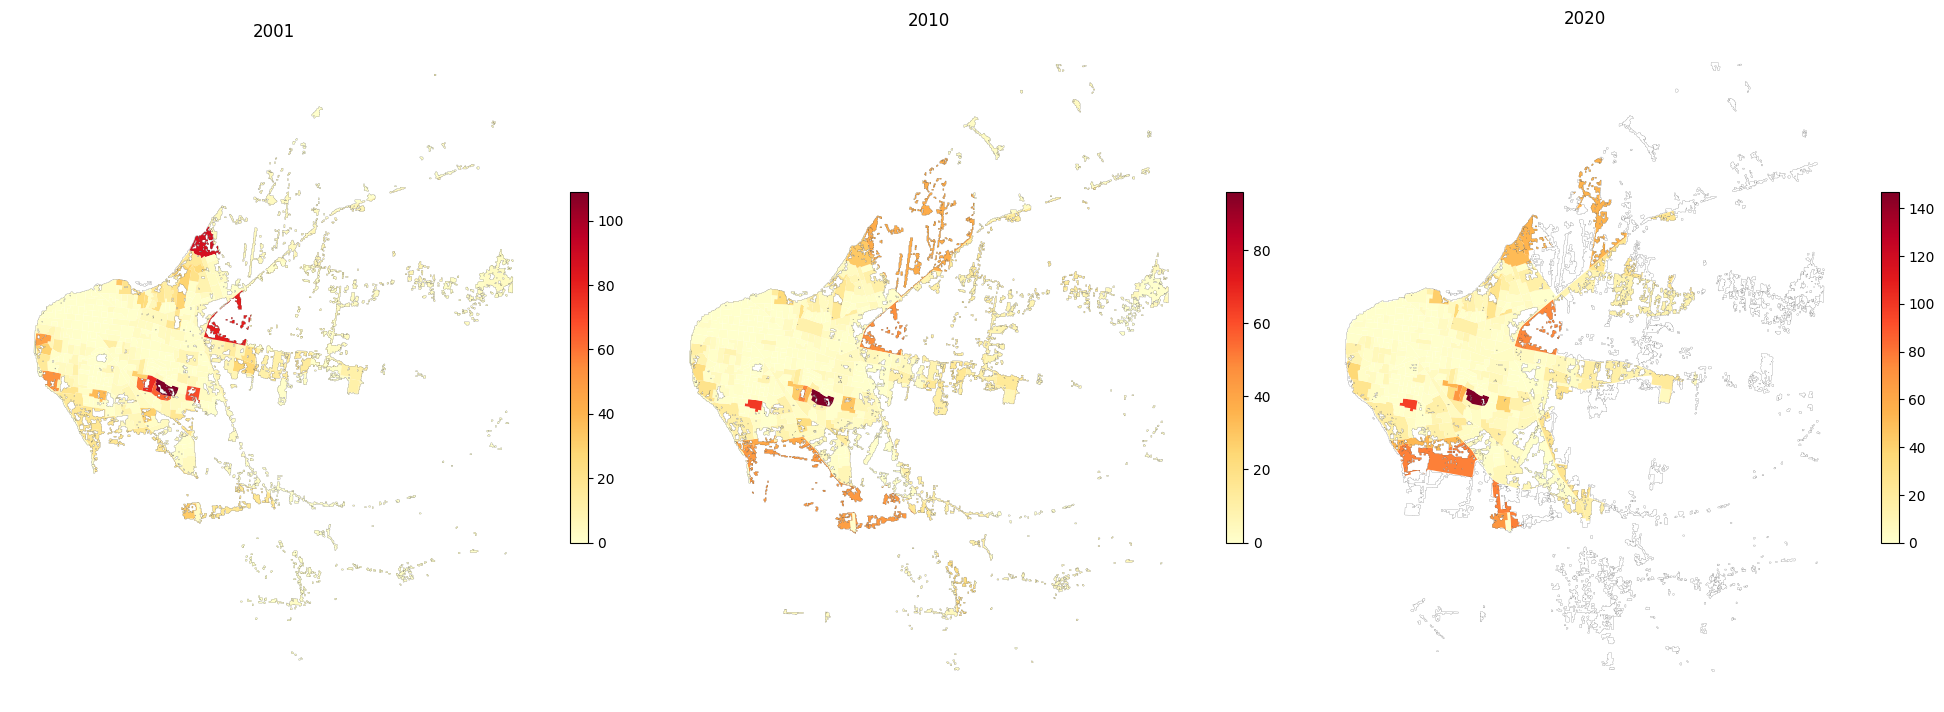

In [13]:
compare_chropleths(
    tipo_vivienda_2001_geo,
    tipo_vivienda_2010_geo,
    tipo_vivienda_2020_geo,
    column=["casilla", "casilla", "cat_sim"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [footpr_corrientes_00,footpr_corrientes_10,footpr_corrientes_20],
    figsize=(20,12),
    colormap = 'YlOrRd'
)

### 2.1. Vectores de calibración

El parámetro `calibration_vector` de la función `simulate_cat_var` permite incluir una nueva distribución observada. En este ejemplo, utilizamos el porcentaje del área de un radio censal cubierta por el polígono de un asentamiento informal.

El diccionario que se utiliza debe especificar dos llaves. Una indicando el objeto que se va a mapear como vector de nuevos pesos ('weights') y otra indicando si esta distribución observada se va a utilizar junto a las de 2001-2010 o no. En este último caso, se debe especificar `mix_dist:False`. Esto significa que las distribuciones definidas con el parámetro `base_year` se sobreescriben. De esta manera la asignación de frecuencias por radio para el año de proyección sólo sigue el vector de pesos definido en la llave `weights` del parametro `calibration_vector`.

In [14]:
import pandas as pd
from CENSAr.spatial_distributions.geo_utils import (from_wkt, build_thiner_pct_in_coarser_geom)

In [15]:
# Superficie cubierta por asentamientos informales
url = "https://storage.googleapis.com/python_mdg/censar_data/informal_settlements_072022.csv"
asentamientos = pd.read_csv(url)
asentamientos_gdf = from_wkt(df=asentamientos, wkt_column='geometry')

tipo_2020_reset = tipo_vivienda_2020_geo.reset_index()
calibration_weights = build_thiner_pct_in_coarser_geom(coarser_geom=tipo_2020_reset, thiner_geom=asentamientos_gdf,
                                                       coarser_idx='link', thiner_idx='id_renabap', crs=5347)

En este caso, vamos a suponer que las viviendas informales representan el 2.7% del total de viviendas proyectado en 2020. Para disrtribuir estos casos por radio censal vamos a seguir una distribución intermedia entre la cantidad de viviendas tipo casilla observadas por radio censal en 2001 y 2010.

Además, vamos a utilizar un vector de calibración para darle mayor relevancia a los radios censales con superficies de asentamientos informales. Para construir este vector de pesos se usa la función `build_thiner_pct_in_coarser_geom`. Lo más importante a tener en cuenta sobre esta es el uso del parametro `coarser_tot`. El default es `True` y significa que las proporciones estimadas por radio censal corresponderán a la superficie del radio cubierta por el polígono del asentamiento informal. De lo contrario, es decir, si se especifica como `False` entonces dicho peso corresponderá al porcentaje de superficie informal que cada radio concentra respecto del total de superficie informal (la suma del área de los polígonos que utilizamos como `thiner_geom`)

In [16]:
simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_vivienda_2001_geo,
    gdf_var_10=tipo_vivienda_2010_geo,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tipo_vivienda_2020_geo,
    pct_val=2.7,
    catname={"2001": "casilla", "2010": "casilla"},
    tot_colname="total_viviendas",
    calibration_vector={'weights':calibration_weights, 'mix_dist':True}
    )

# Simulacion sin parche (no se controlan las relocalizaciones o perdida de casos por radio ni consistencia con totales)
tipo_vivienda_2020_geo["casilla"] = tipo_vivienda_2020_geo["link"].map(simulated_distribution)


{'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'shrink': 0.3}}


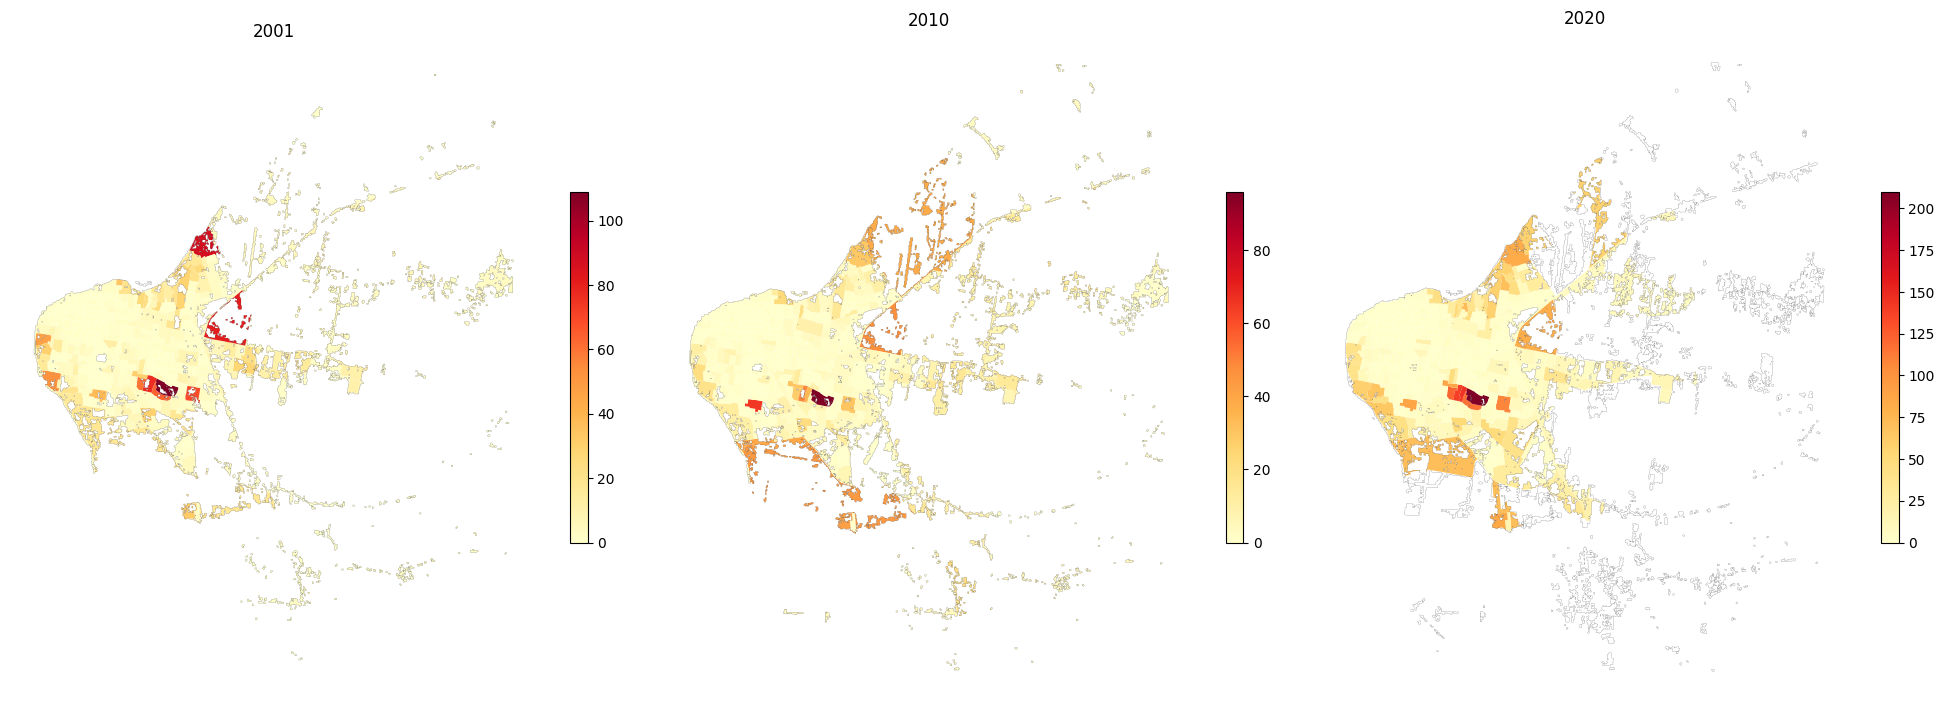

In [17]:
compare_chropleths(
    tipo_vivienda_2001_geo,
    tipo_vivienda_2010_geo,
    tipo_vivienda_2020_geo,
    column=["casilla", "casilla", "casilla"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [footpr_corrientes_00,footpr_corrientes_10,footpr_corrientes_20],
    figsize=(20,12),
    colormap = 'YlOrRd'
)

# 3. Agregacion de indicadores

El módulo `aggregation` permite construir indicadores a partir de la agregación de categorías simples de una variable. Esto, tanto para el universo de hogares como de viviendas. Dicha agregación se configura a partir de los archivos `.yaml` que se encuentran en el mismo directorio.

### 3.1. Informalidad por tipo de vivienda

A continuación se detalla un ejemplo con la variable `tipo de vivienda`. Aquellas categorías que responden a condiciones de informalidad o vulnerabilidad urbanas se agruparan bajo una misma etiqueta. En nuestro caso, [el CNPHV2010 define](https://redatam.indec.gob.ar/redarg/CENSOS/CPV2010rad/Docs/base.pdf) como:

1. `Rancho`: vivienda con salida directa al exterior (sus habitantes no pasan por pasillos o corredores de uso común) construida originalmente para que habiten personas. Generalmente tiene paredes de adobe, piso de tierra y techo de chapa o paja. Se considera propia de áreas rurales.

2. `Casilla`: vivienda con salida directa al exterior, construida originalmente para que habiten personas (sus habitantes no pasan por pasillos o corredores de uso común). Habitualmente está construida con materiales de baja calidad o de desecho y se considera propia de áreas urbanas.  

3. `Local no construido para habitación`: vivienda que no ha sido construida o adaptada para quehabiten personas pero en la que hubo personas que pasaron la noche de referencia del Censo.

In [18]:
from copy import deepcopy
from CENSAr.aggregation import named_aggregation

tipo_vivienda_agg_2001 = named_aggregation(tipo_vivienda_2001_geo, name="tipo vivienda particular")
tipo_vivienda_agg_2010 = named_aggregation(tipo_vivienda_2010_geo, name="tipo vivienda particular")
tipo_vivienda_agg_2020 = deepcopy(tipo_vivienda_2020_geo[['link','total_viviendas','link_2001','link_2010','geometry']])

[11:35:36] INFO     Applying named aggregation `tipo vivienda particular`                                ]8;id=631180;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=217807;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#67\67]8;;\

           WARNING  Extra columns found for mapping situacion de calle: {'persona viviendo en la        ]8;id=338744;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=453767;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#123\123]8;;\
                    calle'}. Extra columns will be ignored.                                                        

           INFO     Applying named aggregation `tipo vivienda particular`                                ]8;id=231383;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=724705;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#67\67]8;;\

           WARNING  Extra columns found for mapping formal: {'casa a', 'pieza en hotel o pension',      ]8;id=386872;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=906174;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#123\123]8;;\
                    'casa b'}. Extra columns will be ignored.                                                      

           WARNING  Extra columns found for mapping situacion de calle: {'persona viviendo en la        ]8;id=761422;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=631046;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#123\123]8;;\
                    calle'}. Extra columns will be ignored.                                                        

In [19]:
formal_simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_vivienda_agg_2001,
    gdf_var_10=tipo_vivienda_agg_2010,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tipo_vivienda_agg_2020,
    pct_val=95,
    catname={"2001": "formal", "2010": "formal"},
    tot_colname="total_viviendas",
)
informal_simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_vivienda_agg_2001,
    gdf_var_10=tipo_vivienda_agg_2010,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tipo_vivienda_agg_2020,
    pct_val=4.5,
    catname={"2001": "informal", "2010": "informal"},
    tot_colname="total_viviendas",
)
calle_simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_vivienda_agg_2001,
    gdf_var_10=tipo_vivienda_agg_2010,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tipo_vivienda_agg_2020,
    pct_val=0.5,
    catname={"2001": "situacion de calle", "2010": "situacion de calle"},
    tot_colname="total_viviendas",
)

# Simulacion sin control de relocalizacion (no se evita la perdida de casos por radio)
tipo_vivienda_agg_2020["formal_sim"] = tipo_vivienda_agg_2020['link'].map(formal_simulated_distribution)
tipo_vivienda_agg_2020["informal_sim"] = tipo_vivienda_agg_2020['link'].map(informal_simulated_distribution)
tipo_vivienda_agg_2020["calle_sim"] = tipo_vivienda_agg_2020['link'].map(calle_simulated_distribution)

# Las distribuciones simuladas se ajustan como proporcion del total estimado para 2020
tipo_vivienda_agg_2020['total_sim'] = tipo_vivienda_agg_2020['formal_sim'] + tipo_vivienda_agg_2020['informal_sim'] + tipo_vivienda_agg_2020['calle_sim'] 
tipo_vivienda_agg_2020['formal_pct'] = round(tipo_vivienda_agg_2020['formal_sim'] / tipo_vivienda_agg_2020['total_sim'], 2) 
tipo_vivienda_agg_2020['informal_pct'] = round(tipo_vivienda_agg_2020['informal_sim'] / tipo_vivienda_agg_2020['total_sim'], 2) 
tipo_vivienda_agg_2020['calle_pct'] = round(tipo_vivienda_agg_2020['calle_sim'] / tipo_vivienda_agg_2020['total_sim'], 2) 

tipo_vivienda_agg_2020['formal'] = round(tipo_vivienda_agg_2020['total_viviendas'] * tipo_vivienda_agg_2020['formal_pct'],0).astype(int) 
tipo_vivienda_agg_2020['informal'] = round(tipo_vivienda_agg_2020['total_viviendas'] * tipo_vivienda_agg_2020['informal_pct'],0).astype(int) 
tipo_vivienda_agg_2020['calle'] = round(tipo_vivienda_agg_2020['total_viviendas'] * tipo_vivienda_agg_2020['calle_pct'],0).astype(int)

In [20]:
# Rechequo de totales
tipo_vivienda_agg_2020[['formal','informal','calle']].sum()

formal      129041
informal      6780
calle          672
dtype: int64

In [21]:
tipo_vivienda_agg_2020[['formal','informal','calle']].sum().sum()

136493

In [22]:
tipo_vivienda_agg_2020['total_viviendas'].sum()

136509

{'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'shrink': 0.3}}


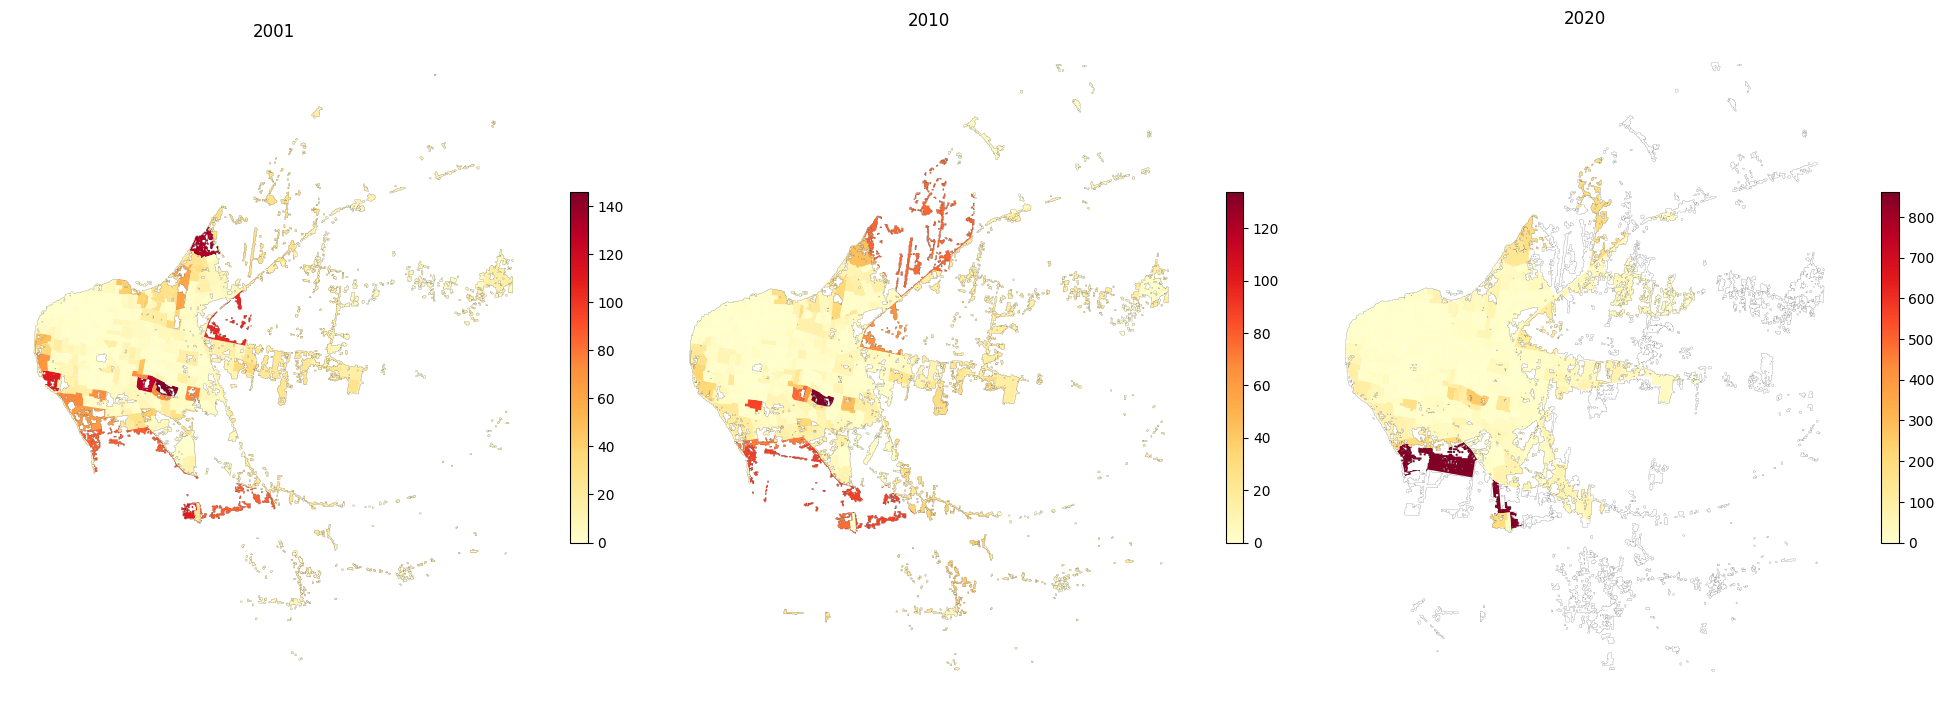

In [23]:
# INFORMAL
compare_chropleths(
    tipo_vivienda_agg_2001,
    tipo_vivienda_agg_2010,
    tipo_vivienda_agg_2020,
    column=["informal","informal","informal"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [footpr_corrientes_00,footpr_corrientes_10,footpr_corrientes_20],
    figsize=(20,12),
    colormap = 'YlOrRd'
)

{'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'shrink': 0.3}}


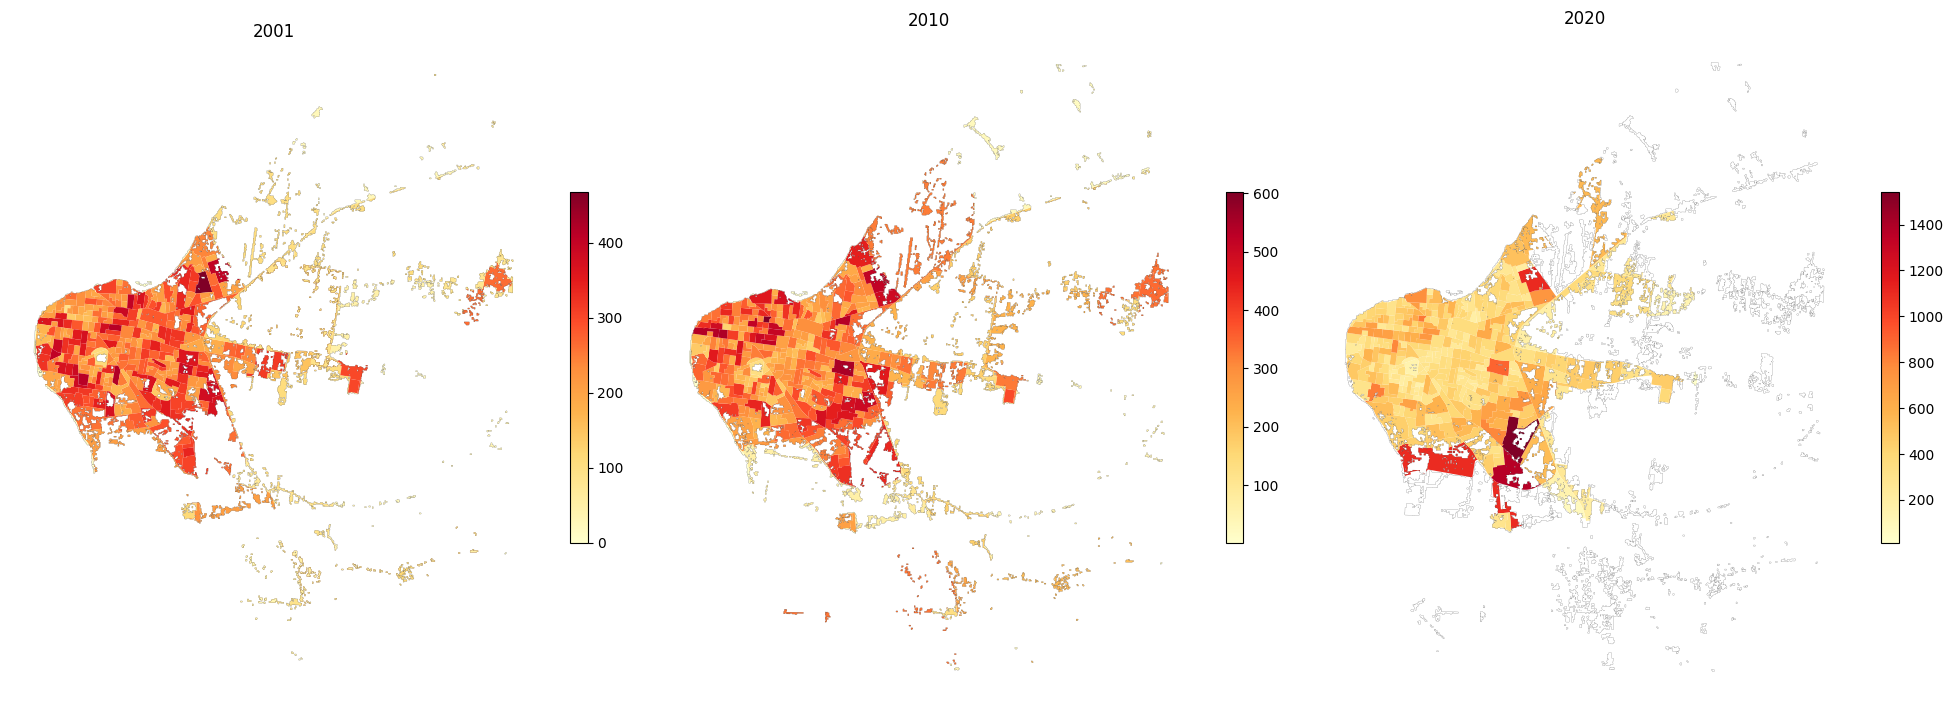

In [24]:
# FORMAL
compare_chropleths(
    tipo_vivienda_agg_2001,
    tipo_vivienda_agg_2010,
    tipo_vivienda_agg_2020,
    column=["formal","formal","formal"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [footpr_corrientes_00,footpr_corrientes_10,footpr_corrientes_20],
    figsize=(20,12),
    colormap = 'YlOrRd'
)

### 3.2. Viviendas informales - totales de referencia

Para determinar cuál es el porcentaje que representa una categoría específica tomamos en cuenta el total de viviendas de las geomtrías que utilizamos como vector de calibración. A continuación revisamos totales de referencia para la categoría `viviendas informales`.

In [25]:
from CENSAr.plots import (
    plot_grouped_bars,
    plot_dist_continvar
    )

In [26]:
# Polígonos de asentamientos informales en los límites del Gran Resistencia
inf_ctes = asentamientos_gdf.loc[(asentamientos_gdf['provincia'].isin(['Corrientes'])) & 
                                  (asentamientos_gdf['departamento'].isin(['Capital']))].copy()

inf_ctes['decada_label'] = inf_ctes.decada_de_creacion.apply(lambda x: x[7:11])

# Tabla con totales de referencia
df = pd.DataFrame(inf_ctes.groupby('decada_label')['cantidad_viviendas_aproximadas'].sum().astype(int))
df_ = df.loc[df.index.isin(['2000','2010']),['cantidad_viviendas_aproximadas']].copy()
df_['viviendas totales (CNPHV)'] = [tipo_vivienda_agg_2001['total'].sum(), tipo_vivienda_agg_2010['total'].sum()]
df_['viviendas informales (tipo - CNPHV)'] = [tipo_vivienda_agg_2001['informal'].sum(), tipo_vivienda_agg_2010['informal'].sum()]
df_.rename(columns={'cantidad_viviendas_aproximadas': 'viviendas informales (Renabap)'}, inplace=True)
df_ = df_[['viviendas informales (Renabap)', 'viviendas informales (tipo - CNPHV)', 'viviendas totales (CNPHV)']].copy()

In [27]:
df_

viviendas informales (Renabap)  \
decada_label                                   
2000                                    1883   
2010                                    2667   

              viviendas informales (tipo - CNPHV)  viviendas totales (CNPHV)  
decada_label                                                                  
2000                                       3732.0                    80922.0  
2010                                       2729.0                   101885.0

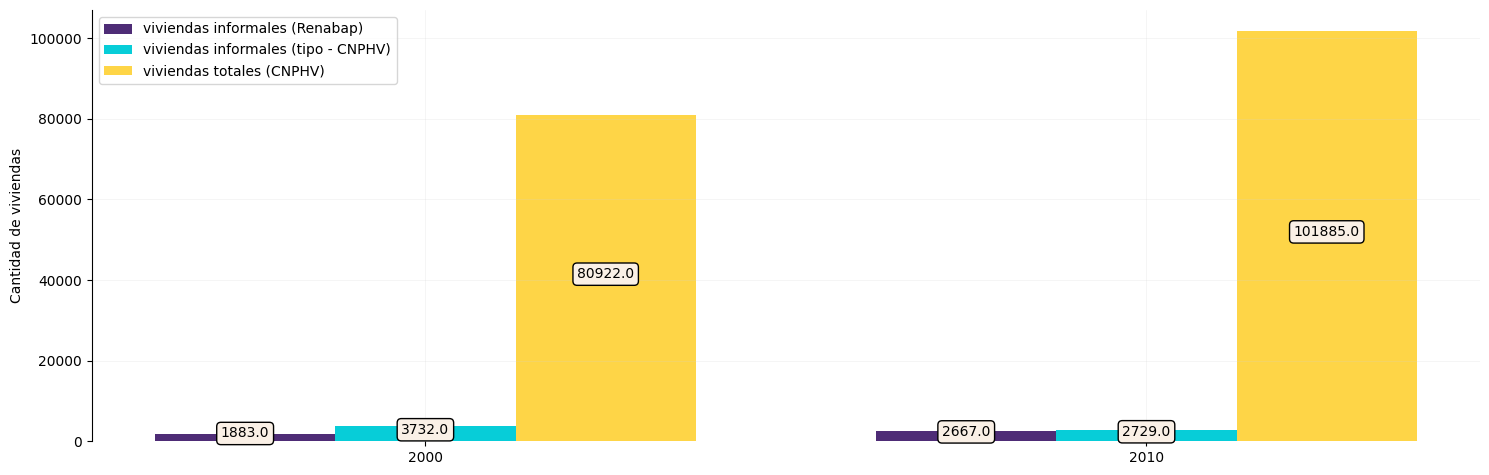

In [28]:
yaxis_formatter=None
xaxis_formatter=None
xticks_rotation = 0

fcolor = 'linen'
tcolor = 'black'

colors = {'viviendas informales (Renabap)':'#4e2c76', 
          'viviendas informales (tipo - CNPHV)':'#07cdd8', 
          'viviendas totales (CNPHV)':'#fed547'}
len_groups = 2
bar_width = 0.25

yaxis_name = 'Cantidad de viviendas'
ylim = None
chart_title = None
figsize=(15,5)

plot_grouped_bars(df_.T, figsize, chart_title, len_groups, bar_width, colors, fcolor, tcolor, yaxis_name, yaxis_formatter, ylim, xaxis_formatter, xticks_rotation)

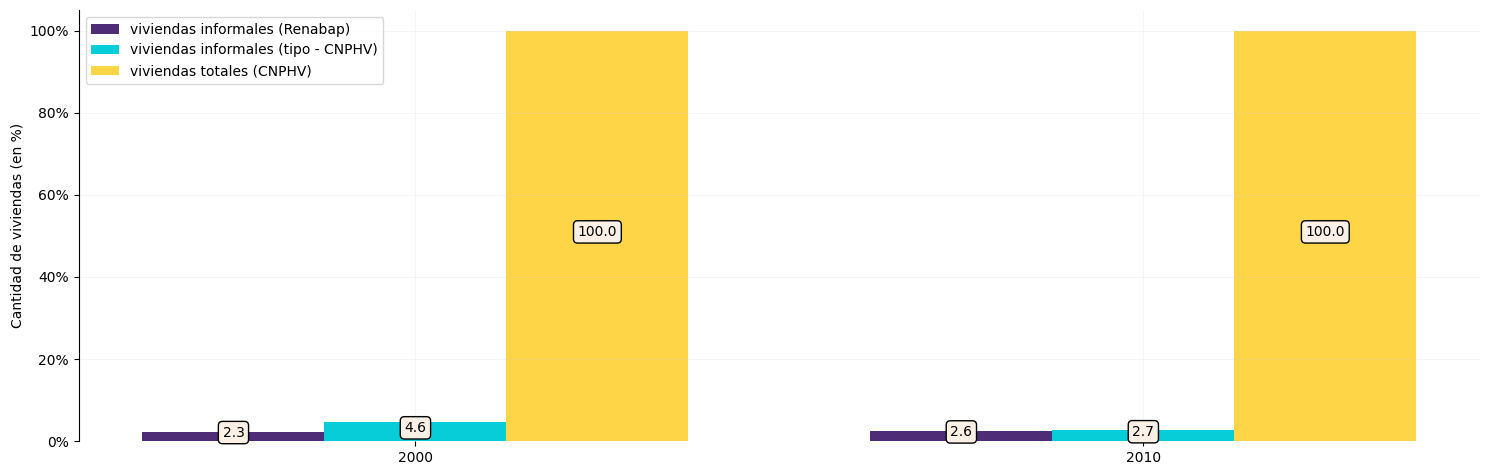

In [29]:
# Tabla con porcentajes de referencia
df_pct = df_.copy()
df_pct['viviendas informales (Renabap)'] = round(df_pct['viviendas informales (Renabap)']/df_pct['viviendas totales (CNPHV)']*100,1)
df_pct['viviendas informales (tipo - CNPHV)'] = round(df_pct['viviendas informales (tipo - CNPHV)']/df_pct['viviendas totales (CNPHV)']*100,1)
df_pct['viviendas totales (CNPHV)'] = round(df_pct['viviendas totales (CNPHV)']/df_pct['viviendas totales (CNPHV)']*100,1)

yaxis_formatter='{}%'

yaxis_name = 'Cantidad de viviendas (en %)'
figsize=(15,5)

plot_grouped_bars(df_pct.T, figsize, chart_title, len_groups, bar_width, colors, fcolor, tcolor, yaxis_name, yaxis_formatter, ylim, xaxis_formatter, xticks_rotation)

{'scheme': 'NaturalBreaks', 'k': 4, 'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'fmt': '{:.0f}'}}


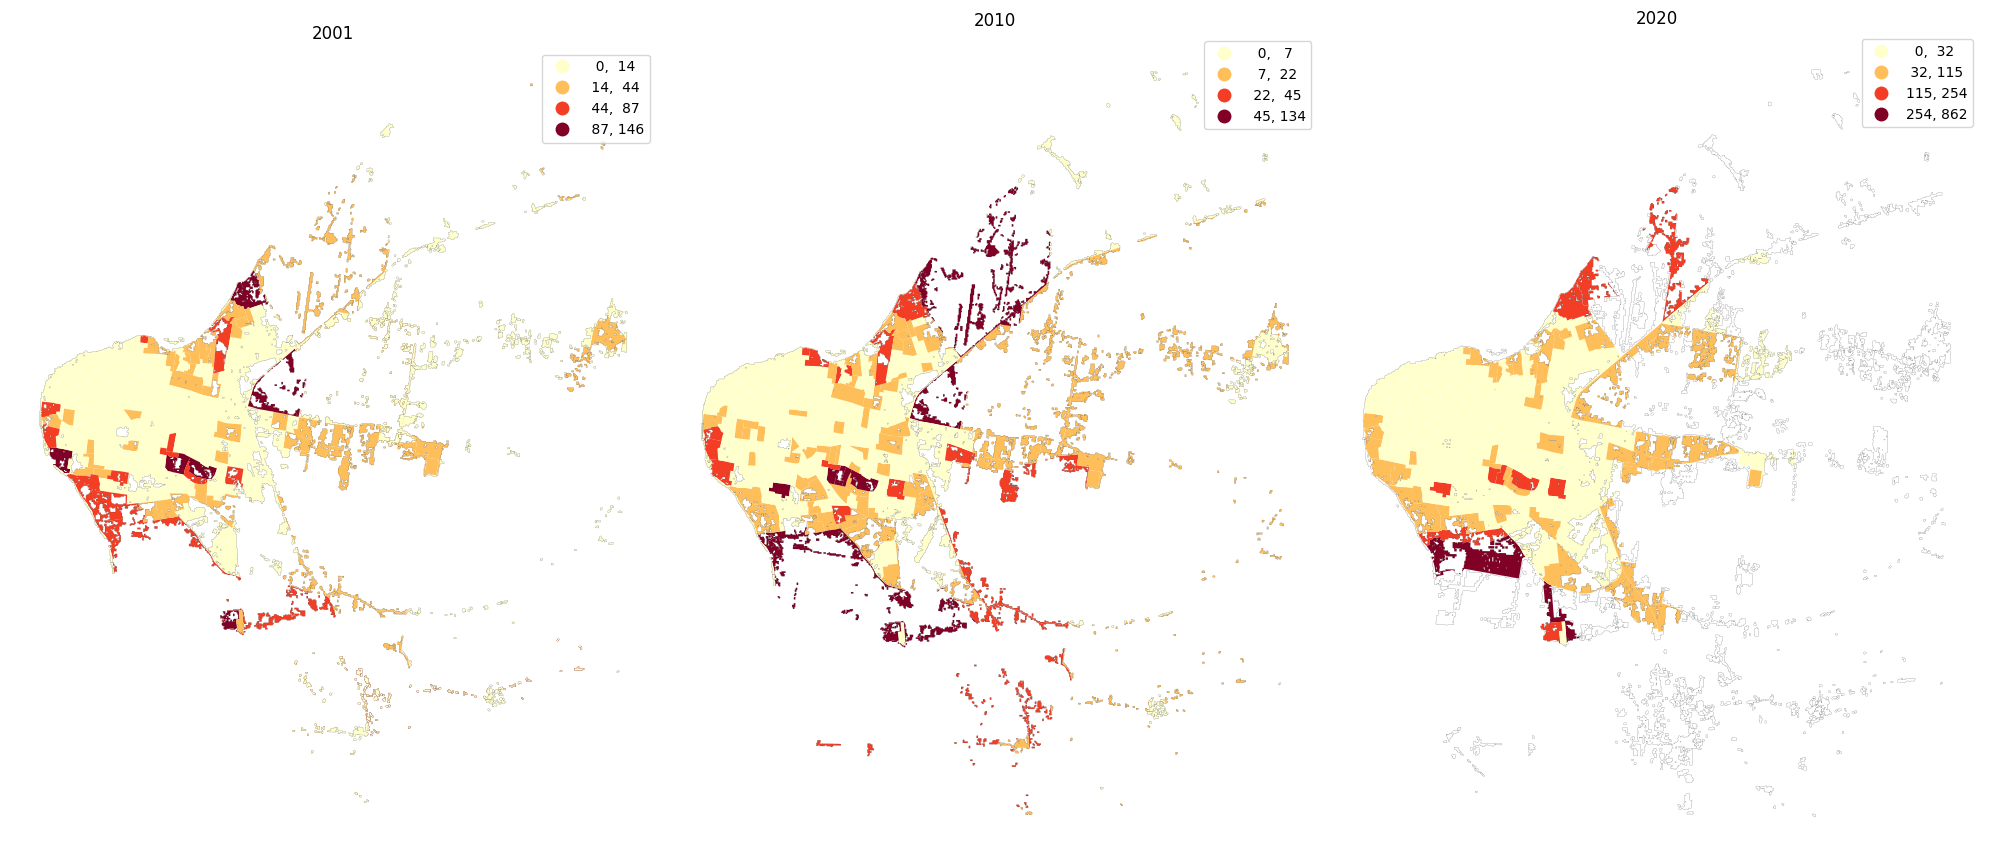

In [30]:
compare_chropleths(
    tipo_vivienda_agg_2001,
    tipo_vivienda_agg_2010,
    tipo_vivienda_agg_2020,
    column=["informal","informal","informal"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [footpr_corrientes_00,footpr_corrientes_10,footpr_corrientes_20],
    figsize=(20,12),
    legend_kwds = {'fmt':'{:.0f}'},
    scheme = "NaturalBreaks",
    k = 4,
    colormap = 'YlOrRd'
)

### 3.3. Distribución de viviendas por radio censal

Ahora vamos a revisar las distribuciones de vivienda por radio censal estimadas para el año de proyección 2020 y evaluar cuánto se parecen a las distribuciones observadas en 2001 y 2010.

#### 3.3.1 Viviendas informales por radio censal 2001

In [31]:
tipo_vivienda_agg_2001['informal'].describe()

count    317.000000
mean      11.772871
std       22.612843
min        0.000000
25%        1.000000
50%        3.000000
75%       11.000000
max      146.000000
Name: informal, dtype: float64

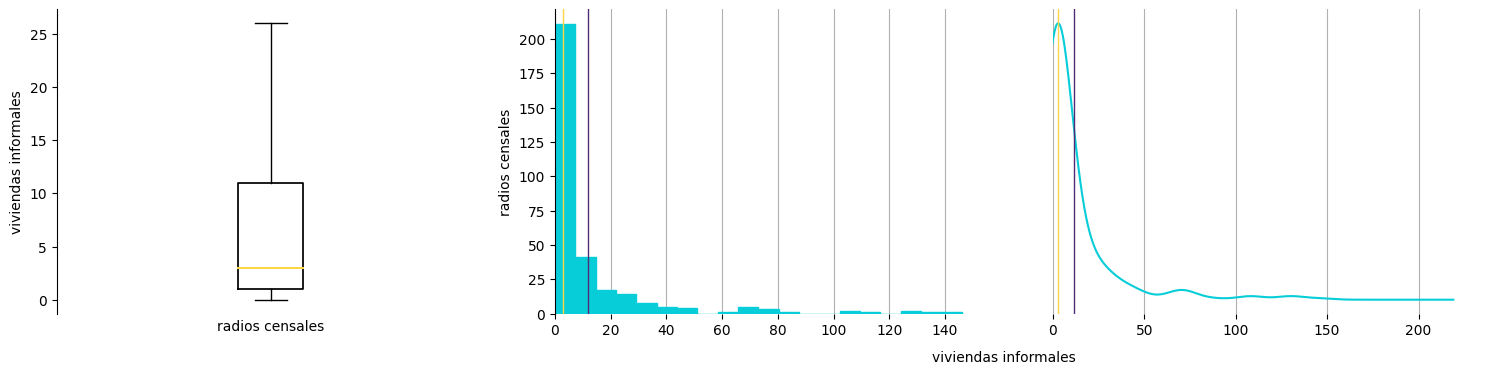

In [32]:
plot_dist_continvar(serie=tipo_vivienda_agg_2001['informal'], figsize=(15,4), fill_hist=True, 
                    xlabel='radios censales', ylabel='viviendas informales', tit=None, bval=20, lim=None)

#### 3.3.2 Viviendas informales por radio censal 2010

In [33]:
tipo_vivienda_agg_2010['informal'].describe()

count    334.000000
mean       8.170659
std       15.653078
min        0.000000
25%        1.000000
50%        3.000000
75%        9.000000
max      134.000000
Name: informal, dtype: float64

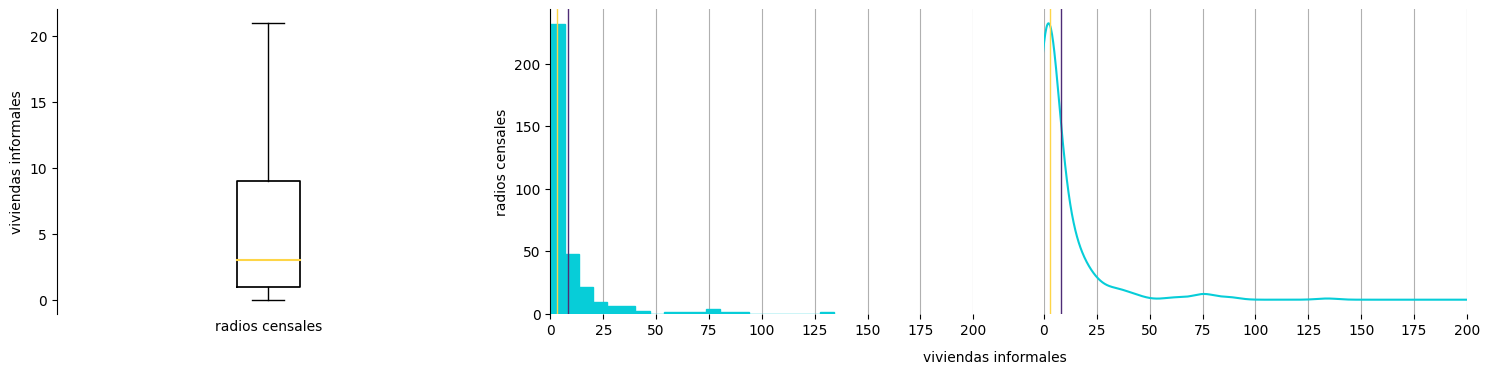

In [34]:
plot_dist_continvar(serie=tipo_vivienda_agg_2010['informal'], figsize=(15,4), fill_hist=True, 
                    xlabel='radios censales', ylabel='viviendas informales', tit=None, bval=20, lim=200)

#### 3.3.3 Viviendas informales por radio censal 2020

In [35]:
tipo_vivienda_agg_2020['informal'].describe()

count    313.000000
mean      21.661342
std       59.381807
min        0.000000
25%        0.000000
50%        6.000000
75%       18.000000
max      862.000000
Name: informal, dtype: float64

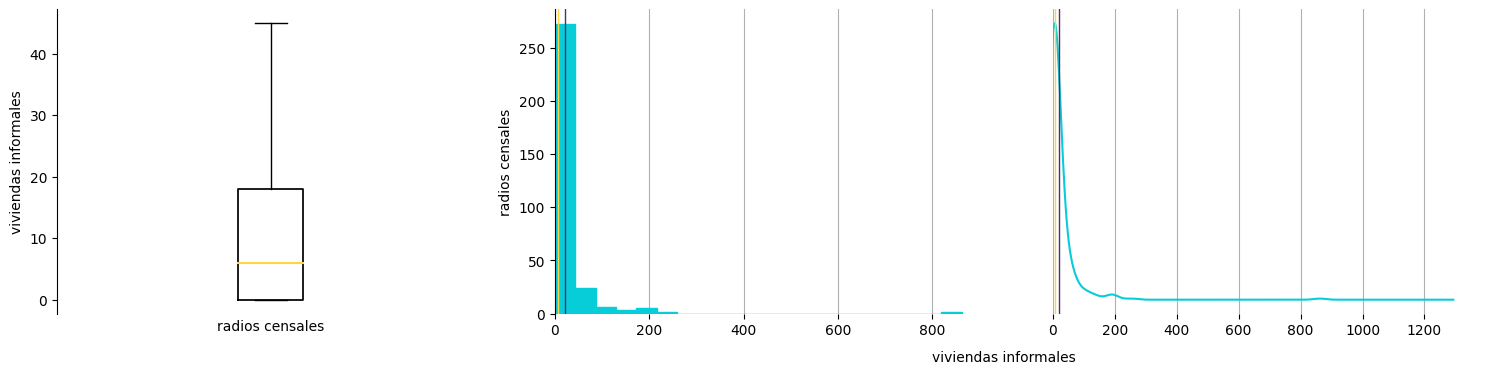

In [36]:
plot_dist_continvar(serie=tipo_vivienda_agg_2020['informal'], figsize=(15,4), fill_hist=True, 
                    xlabel='radios censales', ylabel='viviendas informales', tit=None, bval=20, lim=None)

{'scheme': 'NaturalBreaks', 'k': 4, 'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'fmt': '{:.0%}'}}


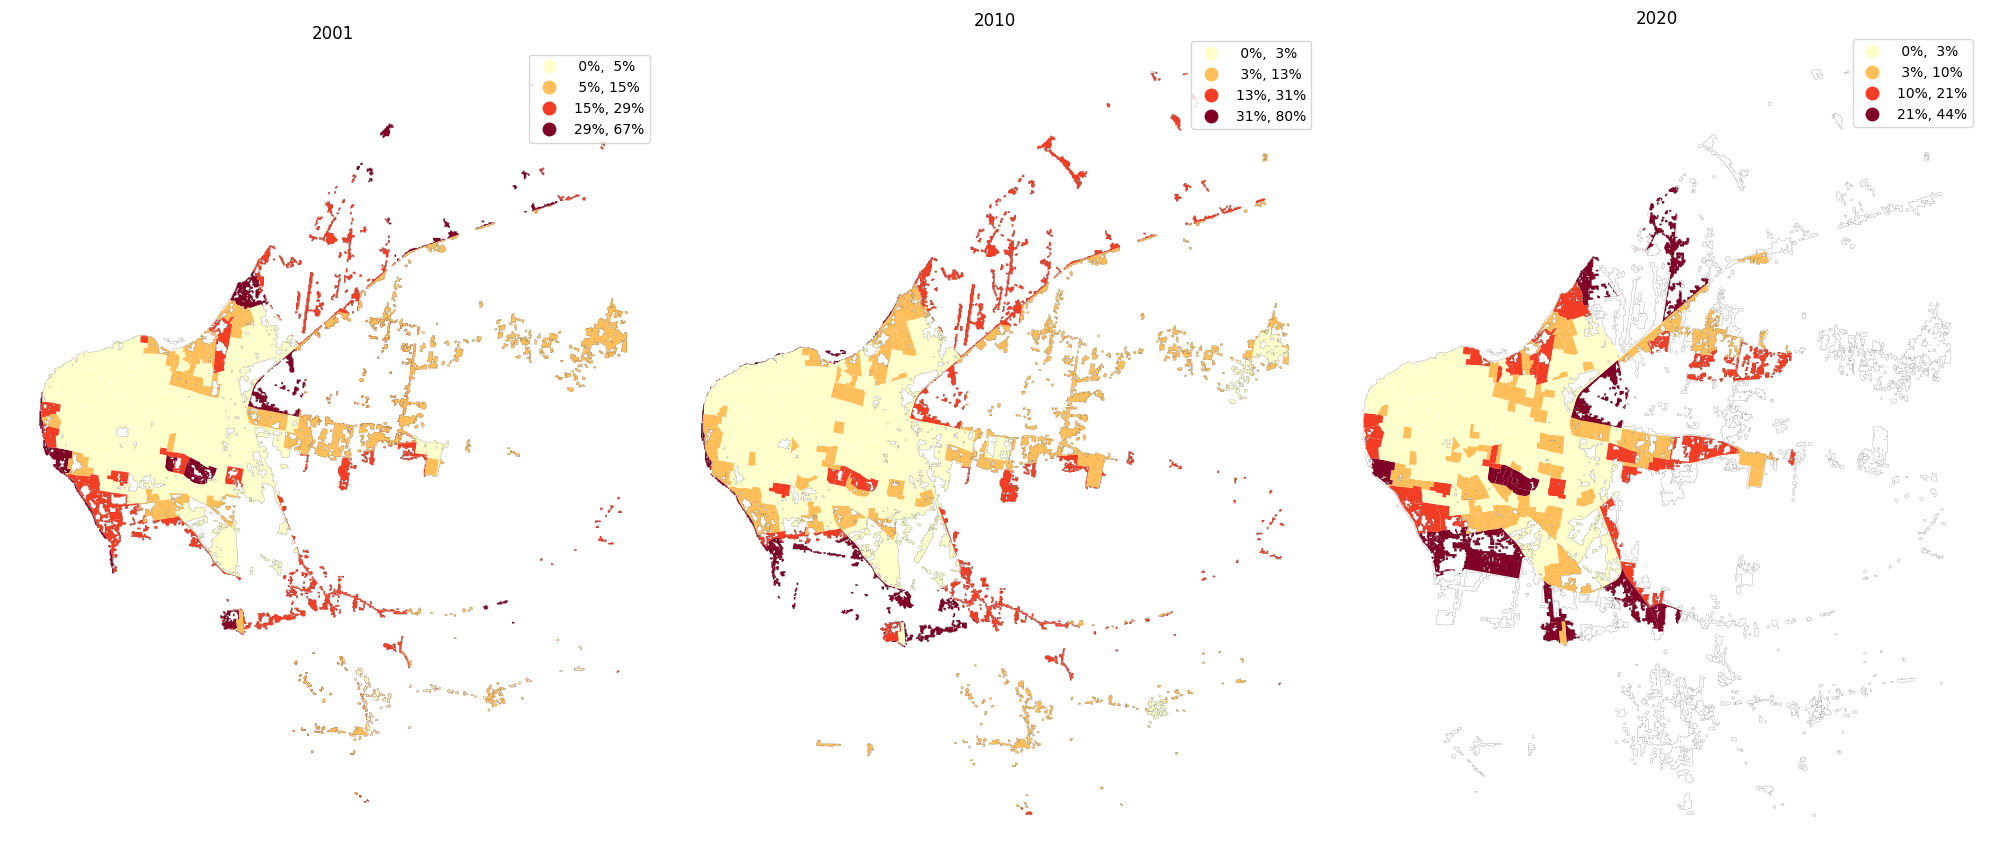

In [37]:
# En procentajes
tipo_vivienda_agg_2020['pct_informal'] = round((tipo_vivienda_agg_2020['informal']/tipo_vivienda_agg_2020['total_viviendas']),2)
tipo_vivienda_agg_2010['pct_informal'] = round((tipo_vivienda_agg_2010['informal']/tipo_vivienda_agg_2010['total']),2)
tipo_vivienda_agg_2001['pct_informal'] = round((tipo_vivienda_agg_2001['informal']/tipo_vivienda_agg_2001['total']),2)

compare_chropleths(
    tipo_vivienda_agg_2001,
    tipo_vivienda_agg_2010,
    tipo_vivienda_agg_2020,
    column=["pct_informal","pct_informal","pct_informal"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [footpr_corrientes_00,footpr_corrientes_10,footpr_corrientes_20],
    figsize=(20,12),
    legend_kwds = {'fmt':'{:.0%}'},
    scheme = "NaturalBreaks",
    k = 4,
    colormap = 'YlOrRd'
)

{'k': 4, 'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'shrink': 0.3}}


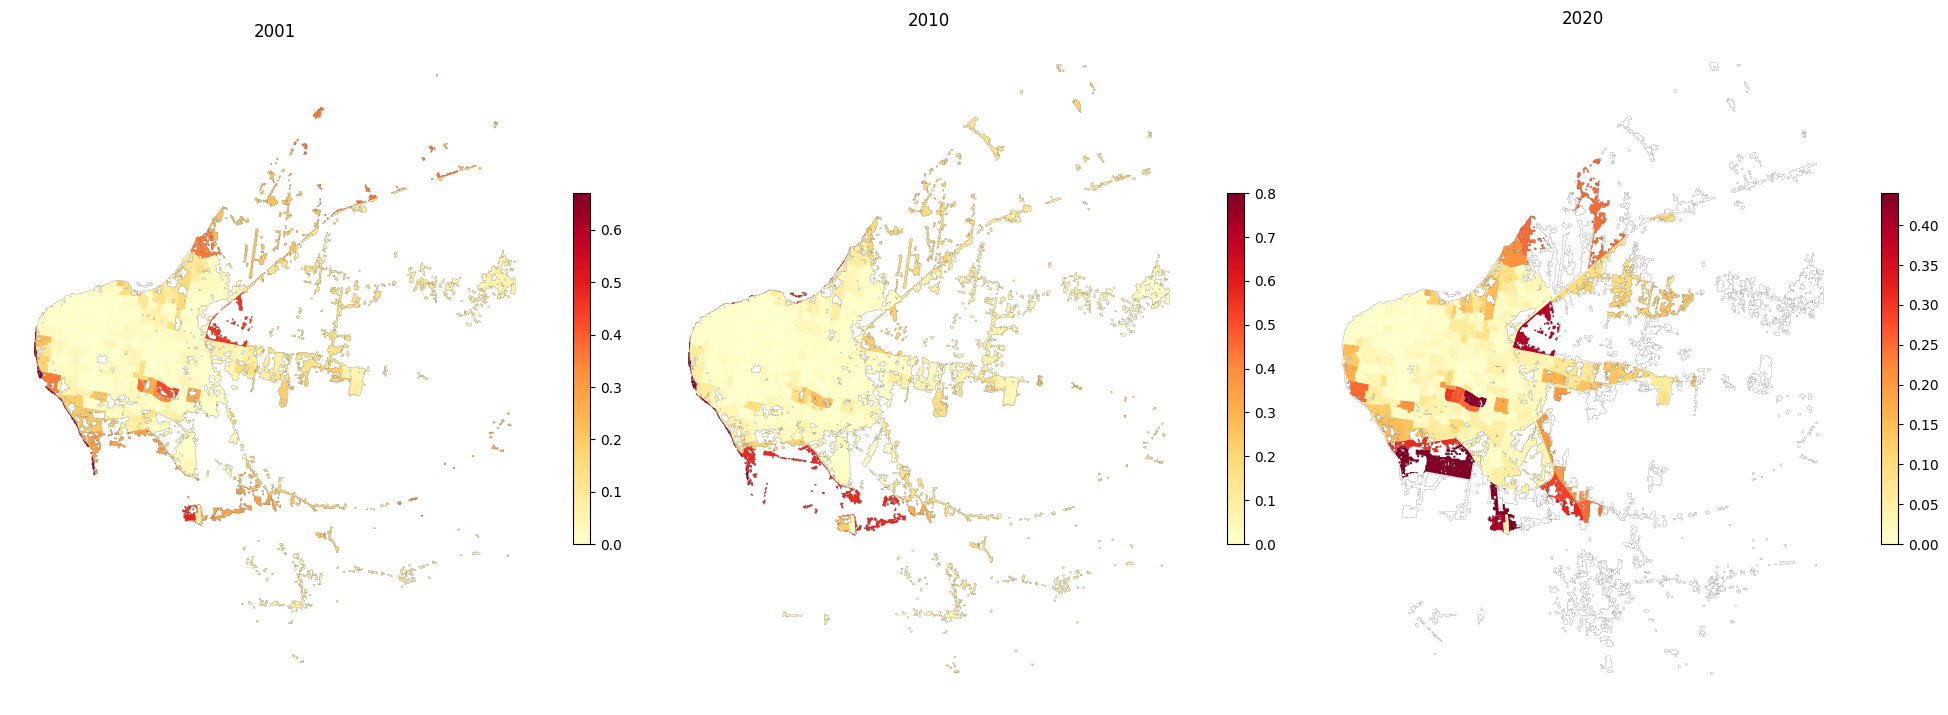

In [38]:
compare_chropleths(
    tipo_vivienda_agg_2001,
    tipo_vivienda_agg_2010,
    tipo_vivienda_agg_2020,
    column=["pct_informal","pct_informal","pct_informal"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [footpr_corrientes_00,footpr_corrientes_10,footpr_corrientes_20],
    figsize=(20,12),
    k = 4,
    colormap = 'YlOrRd'
)

### Otras agregaciones

In [39]:
vulnerabilidad_2001 = named_aggregation(
    tipo_vivienda_agg_2001,
    name="vulnerabilidad urbana",
)
vulnerabilidad_2010 = named_aggregation(
    tipo_vivienda_agg_2010,
    name="vulnerabilidad urbana",
)
vulnerabilidad_2020 = named_aggregation(
    tipo_vivienda_agg_2020,
    name="vulnerabilidad urbana",
)

[11:36:07] INFO     Applying named aggregation `vulnerabilidad urbana`                                   ]8;id=174761;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=682126;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#67\67]8;;\

           INFO     Applying named aggregation `vulnerabilidad urbana`                                   ]8;id=795090;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=412735;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#67\67]8;;\

           INFO     Applying named aggregation `vulnerabilidad urbana`                                   ]8;id=614939;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=618216;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#67\67]8;;\

           WARNING  Extra columns found for mapping vulnerable: {'situacion de calle'}. Extra columns   ]8;id=414157;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=374778;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#123\123]8;;\
                    will be ignored.                                                                               

{'scheme': 'NaturalBreaks', 'k': 4, 'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'fmt': '{:.0f}'}}


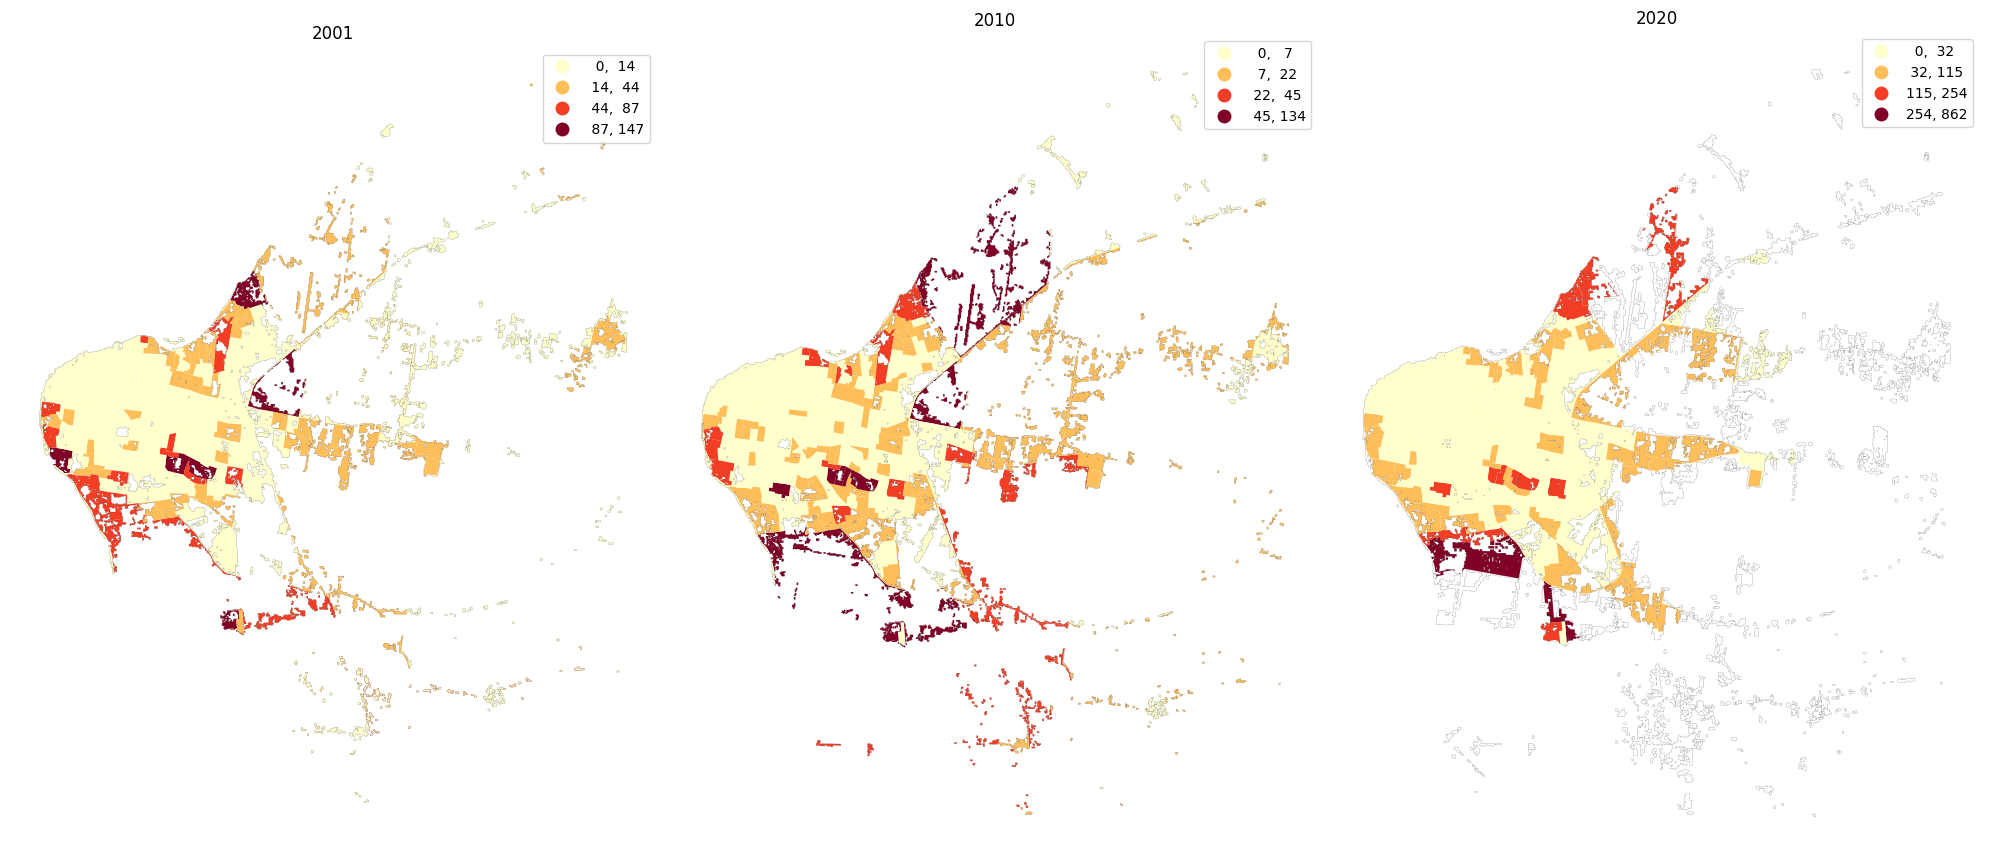

In [40]:
compare_chropleths(
    vulnerabilidad_2001,
    vulnerabilidad_2010,
    vulnerabilidad_2020,
    column=["vulnerable", "vulnerable", "vulnerable"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [footpr_corrientes_00,footpr_corrientes_10,footpr_corrientes_20],
    figsize=(20,12),
    legend_kwds = {'fmt':'{:.0f}'},
    scheme = "NaturalBreaks",
    k = 4,
    colormap = 'YlOrRd'
)

{'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'shrink': 0.3}}


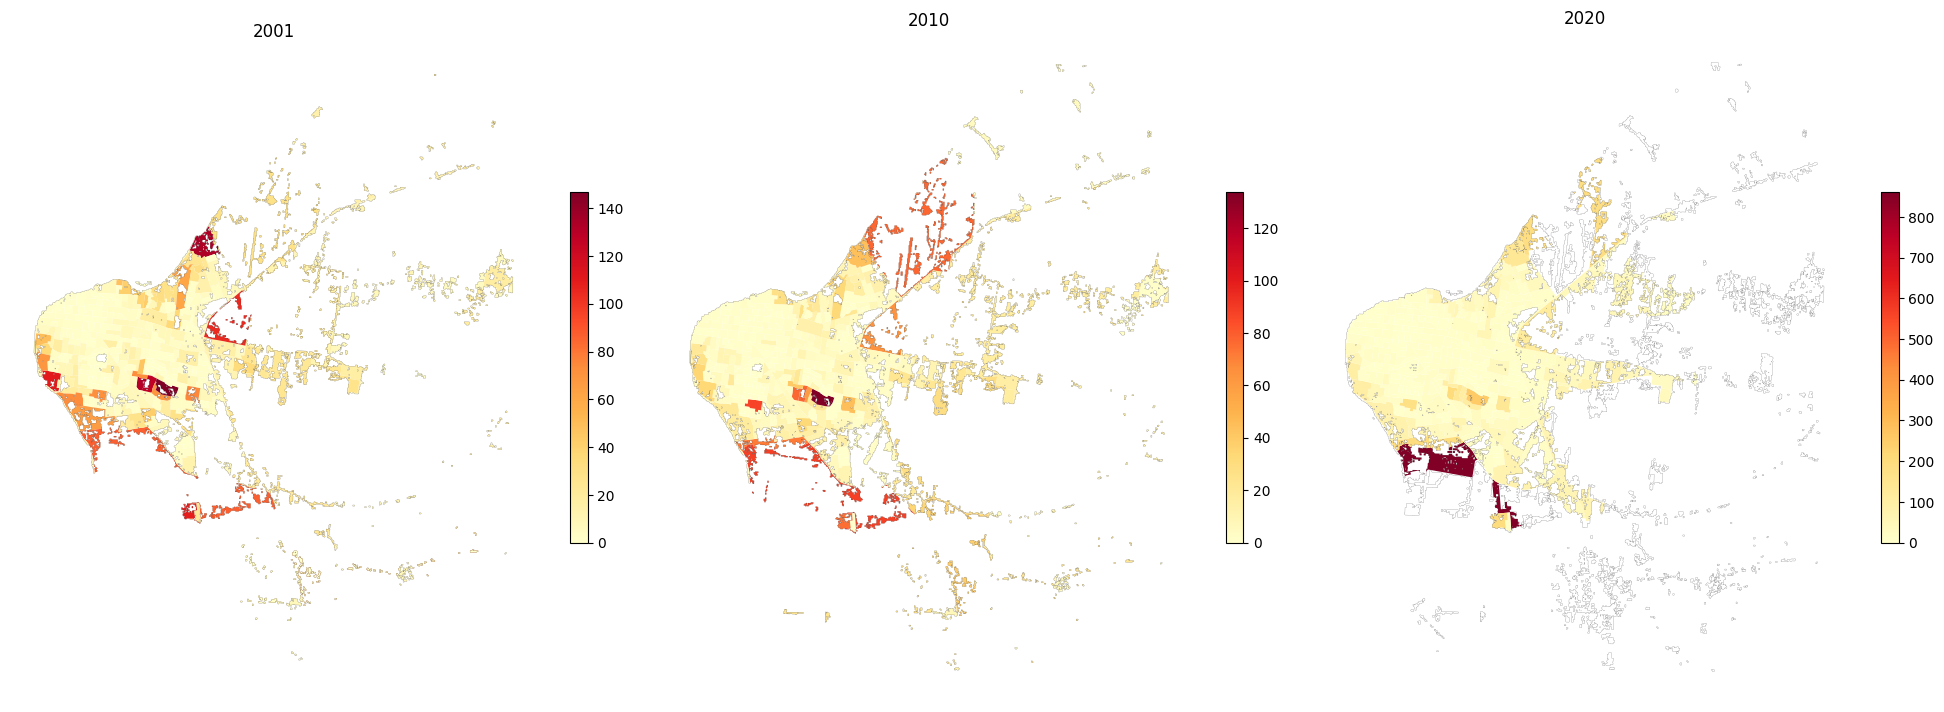

In [41]:
compare_chropleths(
    vulnerabilidad_2001,
    vulnerabilidad_2010,
    vulnerabilidad_2020,
    column=["vulnerable", "vulnerable", "vulnerable"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [footpr_corrientes_00,footpr_corrientes_10,footpr_corrientes_20],
    figsize=(20,12),
    colormap = 'YlOrRd'
)

{'scheme': 'NaturalBreaks', 'k': 4, 'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'fmt': '{:.0f}'}}


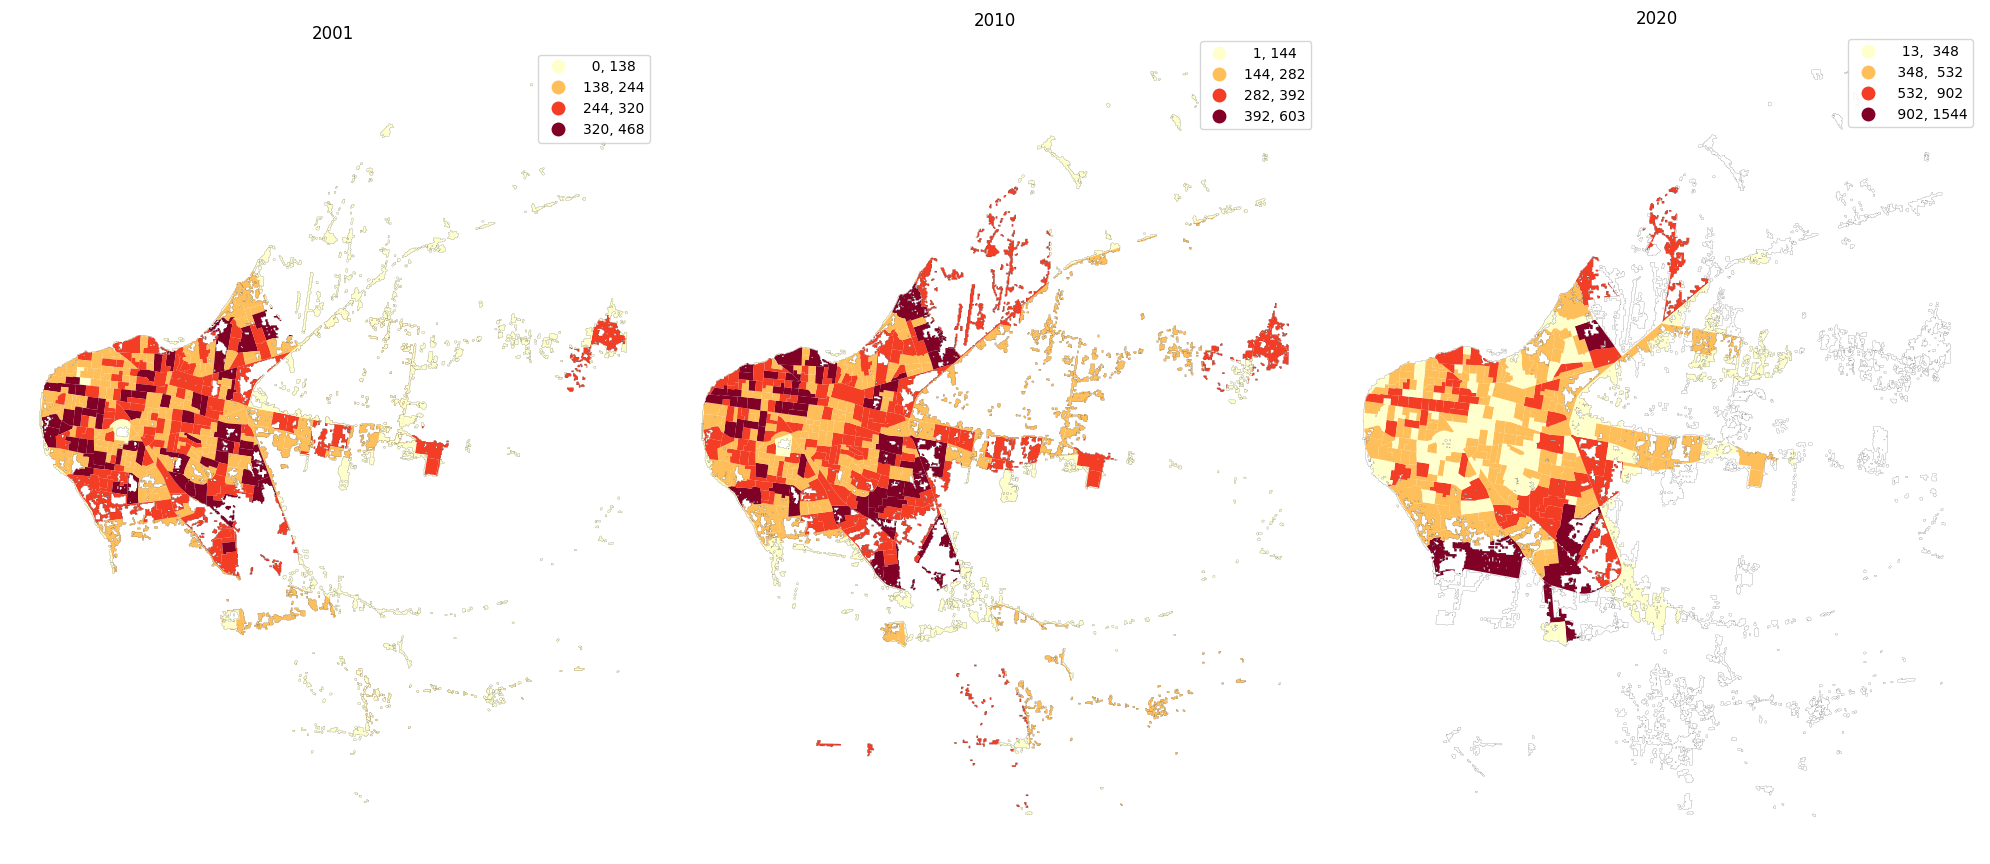

In [42]:
compare_chropleths(
    vulnerabilidad_2001,
    vulnerabilidad_2010,
    vulnerabilidad_2020,
    column=["no vulnerable", "no vulnerable", "no vulnerable"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [footpr_corrientes_00,footpr_corrientes_10,footpr_corrientes_20],
    figsize=(20,12),
    legend_kwds = {'fmt':'{:.0f}'},
    scheme = "NaturalBreaks",
    k = 4,
    colormap = 'YlOrRd'
)

In [43]:
vulnerabilidad_2020['pct_vulnerable'] = round((vulnerabilidad_2020['vulnerable']/vulnerabilidad_2020['total_viviendas']),2)
vulnerabilidad_2010['pct_vulnerable'] = round((vulnerabilidad_2010['vulnerable']/vulnerabilidad_2010['total']),2)
vulnerabilidad_2001['pct_vulnerable'] = round((vulnerabilidad_2001['vulnerable']/vulnerabilidad_2001['total']),2)

{'scheme': 'NaturalBreaks', 'k': 4, 'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'fmt': '{:.0%}'}}


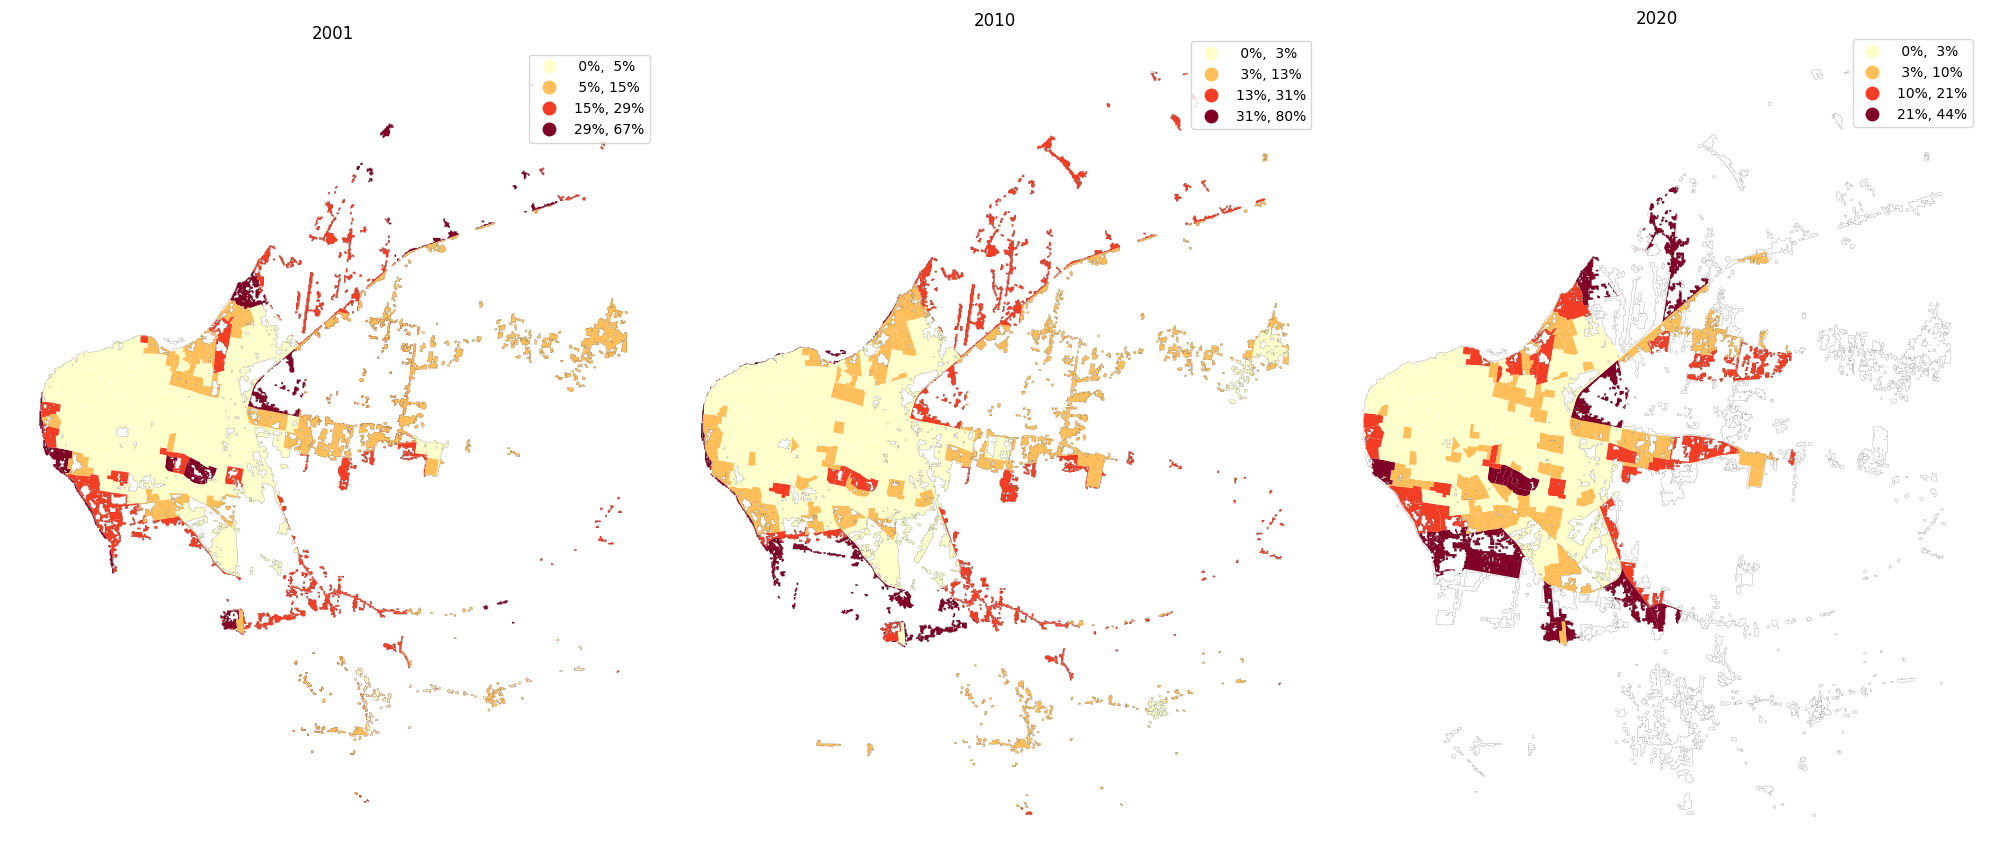

In [44]:
compare_chropleths(
    vulnerabilidad_2001,
    vulnerabilidad_2010,
    vulnerabilidad_2020,
    column=["pct_vulnerable","pct_vulnerable","pct_vulnerable"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [footpr_corrientes_00,footpr_corrientes_10,footpr_corrientes_20],
    figsize=(20,12),
    legend_kwds = {'fmt':'{:.0%}'},
    scheme = "NaturalBreaks",
    k = 4,
    colormap = 'YlOrRd'
)

{'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'shrink': 0.3}}


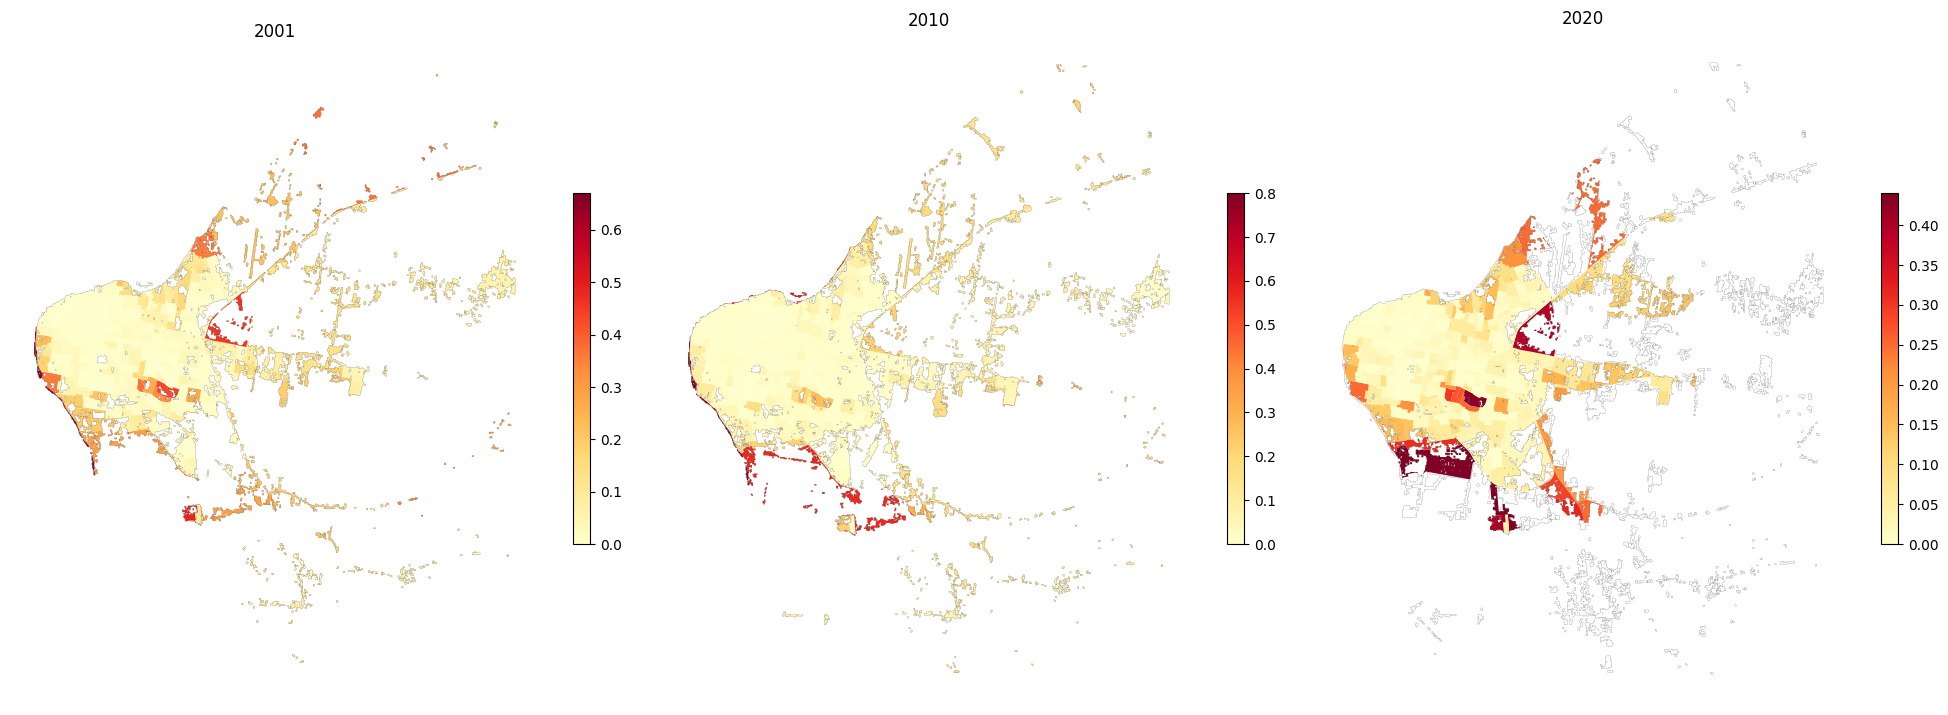

In [45]:
compare_chropleths(
    vulnerabilidad_2001,
    vulnerabilidad_2010,
    vulnerabilidad_2020,
    column=["pct_vulnerable","pct_vulnerable","pct_vulnerable"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [footpr_corrientes_00,footpr_corrientes_10,footpr_corrientes_20],
    figsize=(20,12),
    colormap = 'YlOrRd'
)